<a href="https://colab.research.google.com/github/dianahz/PyTorch-ImageSegmentation/blob/main/PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#set up colab GPU runtime environment
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 32.2 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6e58112c08a88b37b1c7bb6e4a9a3cb59d53d19ca6b8099a1aefae336ff8d416
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=08b16ea5b5c06cb1f851ec3ec68756b492b0f45a5f51c1e71a7f260bc15e1c3d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dflrof2s
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dflrof2s
   

In [3]:
#original author of the dataset : https://github.com/VikramShenoy97/Human-Segmentation-Dataset
#A dataset with 300 images of humans with some background and a corresponding binary mask for each of these images.
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 22.14 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [6]:
#setup configurations
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

DEVICE = 'cuda'

EPOCHS = 30
LR = 0.001
IMAGE_SIZE = 320
#IMAGE_SIZE = 224
#IMAGE_SIZE = 512
BATCH_SIZE = 20

ENCODER = 'timm-efficientnet-b0'
#ENCODER = 'resnet18'
#ENCODER = 'VGG'
WEIGHTS = 'imagenet'


In [7]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
#check the data (image & mask)

row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

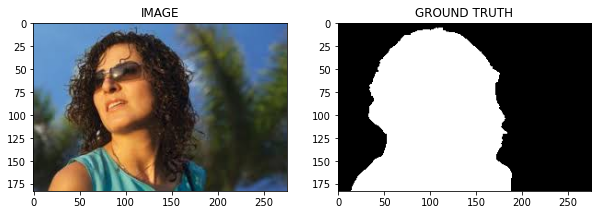

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

#ax2.set_title('MASK)
#ax2.imshow(mask)


In [10]:
#split the train and valid set
train_df, valid_df = train_test_split(df,test_size = 0.2, random_state = 42)

# Data Augmentation

In [11]:
import albumentations as A
#albumentation documentation : https://albumentations.ai/docs/
#enable simutaneous augmentations

In [12]:
def get_train_augs():
  return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

#Create dataset

In [13]:
from torch.utils.data import Dataset 

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


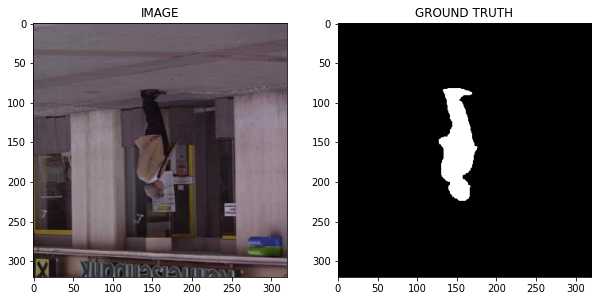

In [18]:
idx = 5

image, mask = trainset[idx]
helper.show_image(image, mask)

# Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [21]:
print(f"total # of batches in trainloader : {len(trainloader)}")
print(f"total # of batches in validloader : {len(validloader)}")

total # of batches in trainloader : 12
total # of batches in validloader : 3


In [22]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([20, 3, 320, 320])
One batch mask shape : torch.Size([20, 1, 320, 320])


# Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [24]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [25]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Train and Validation Function 

In [26]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in data_loader:

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

    

In [27]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Train

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [29]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saving mode")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_Loss : {train_loss} Valid_Loss : {valid_loss}")

100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Saving mode
Epoch : 1 Train_Loss : 0.9315706839164098 Valid_Loss : 0.6230005224545797


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Saving mode
Epoch : 2 Train_Loss : 0.4584175298611323 Valid_Loss : 0.2944317062695821


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Saving mode
Epoch : 3 Train_Loss : 0.30921782304843265 Valid_Loss : 0.2460086097319921


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Saving mode
Epoch : 4 Train_Loss : 0.23015009115139642 Valid_Loss : 0.2263165364662806


100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


Saving mode
Epoch : 5 Train_Loss : 0.23002114271124205 Valid_Loss : 0.20036186774571738


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Epoch : 6 Train_Loss : 0.21287255237499872 Valid_Loss : 0.233361025651296


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Saving mode
Epoch : 7 Train_Loss : 0.17415078977743784 Valid_Loss : 0.18419918417930603


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Saving mode
Epoch : 8 Train_Loss : 0.15626879346867403 Valid_Loss : 0.1748991161584854


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Epoch : 9 Train_Loss : 0.15408203937113285 Valid_Loss : 0.19134625295797983


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Saving mode
Epoch : 10 Train_Loss : 0.13350028110047182 Valid_Loss : 0.16434221466382345


100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Saving mode
Epoch : 11 Train_Loss : 0.11492804437875748 Valid_Loss : 0.14430821438630423


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Epoch : 12 Train_Loss : 0.13436740326384702 Valid_Loss : 0.16723956167697906


100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


Epoch : 13 Train_Loss : 0.11699774488806725 Valid_Loss : 0.1955699771642685


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Epoch : 14 Train_Loss : 0.10926039144396782 Valid_Loss : 0.20077749093373617


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Epoch : 15 Train_Loss : 0.1176943729321162 Valid_Loss : 0.15395171443621317


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Epoch : 16 Train_Loss : 0.12005073515077432 Valid_Loss : 0.19778976837793985


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Epoch : 17 Train_Loss : 0.10481447105606397 Valid_Loss : 0.16919842114051184


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Epoch : 18 Train_Loss : 0.09787282596031825 Valid_Loss : 0.15375186502933502


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Epoch : 19 Train_Loss : 0.09918672467271487 Valid_Loss : 0.1665977934996287


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Epoch : 20 Train_Loss : 0.0998964508374532 Valid_Loss : 0.15066236009200415


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Epoch : 21 Train_Loss : 0.0921792450050513 Valid_Loss : 0.14787865181763968


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Epoch : 22 Train_Loss : 0.09744417046507199 Valid_Loss : 0.1566072553396225


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Saving mode
Epoch : 23 Train_Loss : 0.08176156878471375 Valid_Loss : 0.14142324527104697


100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Epoch : 24 Train_Loss : 0.08272465194265048 Valid_Loss : 0.1468904713789622


100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


Epoch : 25 Train_Loss : 0.08252836608638366 Valid_Loss : 0.14664687712987265


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Saving mode
Epoch : 26 Train_Loss : 0.07975171909977992 Valid_Loss : 0.1402216230829557


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Epoch : 27 Train_Loss : 0.0737866461277008 Valid_Loss : 0.141583780447642


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Epoch : 28 Train_Loss : 0.06682581609735887 Valid_Loss : 0.14223483701546988


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Saving mode
Epoch : 29 Train_Loss : 0.06699972444524367 Valid_Loss : 0.13775921861330667


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

Epoch : 30 Train_Loss : 0.060403088107705116 Valid_Loss : 0.14439414938290915


# Check results

In [30]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

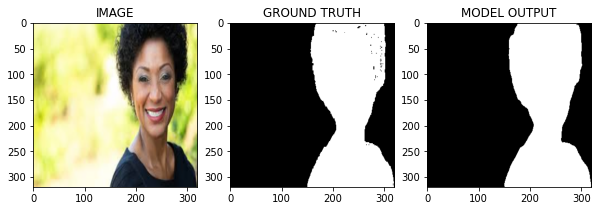

In [31]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))